#Training a Neural Networks to identify a a Bi-Partite Graph. 


In [ ]:
!pip install dgl-cu101

     |████████████████████████████████| 25.5MB 45.9MB/s 


In [ ]:
import dgl
import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
print ("DGL Version:", dgl.__version__)

DGL Version: 0.5.2


## A Graph Adjaceny matrix represenation
The Graph $G=<V,E>$  can be represent with Adjaceny matrix in which $A_{ij} = 1$ , where there is a Edge betwen $E_1$ and $E_2$, otherwise $A_{ij} = 0$. 

### The Graph Data Generators. 

1. Build a random Graph based on [Erdős–Rényi model](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model), using the code example from [networkx library](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_erdos_renyi.html)

In [ ]:
class GenData():
  def Generate(self):
    pass

class GenDataRandom(GenData):
  def __init__(self, vertix_count):
    self.dim = vertix_count 
  def Generate(self):
    A = (np.random.rand( self.dim,  self.dim) > 0.5) * 1
    # remove unneccasry self node edges. 
    for i in range(0, self.dim-1): 
      A[i,i] = 0
    return A

class Graph:
  def __init__(self, data_gen, label='graph'):
    self.A = data_gen.Generate()
    self.createDglGraph()
    self.label = label

  def createDglGraph(self):
    a = sparse.coo_matrix(self.A) 
    self.dgl = dgl.from_scipy(a)

  def plot(self):
    size = self.dgl.num_nodes()
    fig, ax = plt.subplots()
    nx.draw(self.dgl.to_networkx().to_undirected(), ax=ax, with_labels=True)
    ax.set_title(f'Class: {self.label}')
    plt.show()


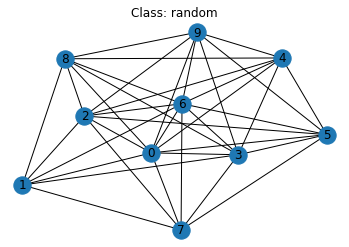

In [ ]:
dg = GenDataRandom(10)
gg = Graph(dg, 'random')
gg.plot()

###Bi-Partite Graphs
a bipartite graph (or bigraph) is a graph whose vertices can be divided into two disjoint and independent sets $U$ and $V$ such that every edge connects a vertex in $U$ to one in $V$. Vertex sets $U$ and $V$ are usually called the parts of the graph.
The adjacency matrix $A$ of a bipartite graph whose two parts have $r$ and $s$ vertices can be written in the form
$
A=\begin{pmatrix}0_{r,r}&B\\B^{T}&0_{s,s} \end{pmatrix} $


In [ ]:
class GenDataBiPartite(GenData):
  def __init__(self, vertix_count):
    self.dim = int(vertix_count / 2) 
  def Generate(self):
    b = (np.random.rand(self.dim, self.dim) > 0.5) * 1
    z = np.zeros((self.dim,self.dim), dtype=int) 
    a = np.concatenate((np.concatenate((z, b), axis=0), np.concatenate((b.T,z), axis=0)), axis = 1)
    return a
    
def plotBiPartiteGraph(graph):
  size = graph.dgl.num_nodes()
  fig, ax = plt.subplots()
  arr =  np.concatenate([np.array(['cyan' for x in range(int(size/2))], dtype=np.str), np.array(['yellow' for x in range(int(size/2))], dtype=np.str)])
  pos = dict()
  pos.update( (i, (1, i)) for i in range(int(size/2)) ) # put nodes from X at x=1
  pos.update( (i + int(size/2), (2, i)) for i in range(int(size/2)) ) # put nodes from Y at x=2
  nx.draw(graph.dgl.to_networkx().to_undirected(), pos=pos, ax=ax, node_color=arr, with_labels=True)
  ax.set_title(f'Class: {graph.label}')
  plt.show()

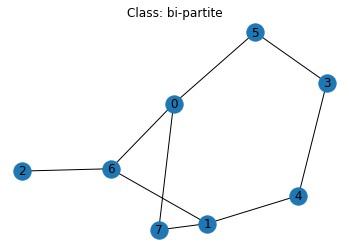

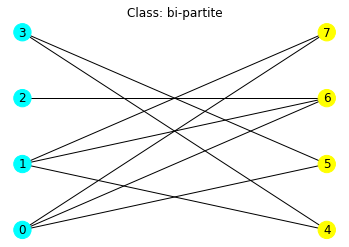

In [ ]:
dg = GenDataBiPartite(8)
gg = Graph(dg, 'bi-partite')
gg.plot()
plotBiPartiteGraph(gg)

## DGL

Notes: 
1. We would like to check whether the GCN can idetify a bipartite graph
1. as a traing data we need to create a _labeled_ dataset that contains bi-partite graphs, random graphs, and almost bi-partite graphs, by taking a bi-partite graph and poluting it with edges between nodes in the same sets.  
1. There are some kinds of generators from networkX. It is described library : [NetworkX-bipartite](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.bipartite.html?highlight=bipartite)

## Graph Classification 
Based on [Graph Classification Tutorial](https://docs.dgl.ai/en/0.4.x/tutorials/basics/4_batch.html)

# DataSet

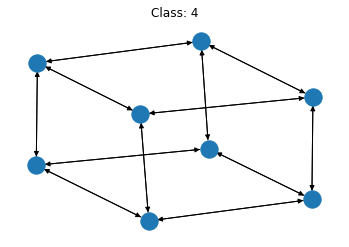

In [ ]:
# an example for a dataset that come out of the box with DGL. 

from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[40]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [ ]:
# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)

print(trainset.num_classes)
print(testset.num_classes)

8
8


## Create the Dataset

Parameters:	
- num_graphs (int) – Number of graphs in this dataset.
- min_num_v (int) – Minimum number of nodes for graphs
- max_num_v (int) – Maximum number of nodes for graphs

In [ ]:
"""A mini synthetic dataset for graph classification benchmark."""
class GraphRandomSet(object):
  """The dataset class.
  The datset contains 2 different types of graphs.
  * class 0 : non bi-partite 
  * class 1 : bi-partite
  .. note::
      This dataset class is compatible with pytorch's :class:`Dataset` class.
  Parameters
  ----------
  num_graphs: int
      Number of graphs in this dataset.
  min_num_v: int
      Minimum number of nodes for graphs
  max_num_v: int
      Maximum number of nodes for graphs
  """
  def __init__(self, num_graphs, min_num_v, max_num_v, data_generators):
    super(BiPartiteRandomSet, self).__init__()
    self.num_graphs = num_graphs
    self.min_num_v = min_num_v
    self.max_num_v = max_num_v
    self.graphs = []
    self.labels = []
    self._generate()
#    rands_num = np.rand.randint(min_num_v, max_num_v, num_graph)
#    for r in rands_num:
#      graphs_col.append(createDglGraph(generateBiPartiteGraphAdjacencyMatrix(r)))

  def __len__(self):
        """Return the number of graphs in the dataset."""
        return len(self.graphs)

  def __getitem__(self, idx):
    """Get the i^th sample and returns (dgl.DGLGraph, int)
        The graph and its label.
    """
    return self.graphs[idx], self.labels[idx]

  @property
  def num_classes(self):
    """Number of classes."""
    return 2

  def _generate(self):
      # preprocess
      for i in range(1, self.num_graphs, self.num_classes):
        self.graphs[i] = DGLGraph(self.graphs[i])
        # add self edges
        nodes = self.graphs[i].nodes()
        self.graphs[i].add_edges(nodes, nodes)

  def _gen_(self, n):
    for _ in range(n):
      num_v = np.random.randint(self.min_num_v, self.max_num_v)
      g = nx.cycle_graph(num_v)
      self.graphs.append(g)
      self.labels.append(0)

  def _gen_random(self, n):
        for _ in range(n):
            num_v = np.random.randint(self.min_num_v, self.max_num_v)
            # nx.star_graph(N) gives a star graph with N+1 nodes
            g = nx.star_graph(num_v - 1)
            self.graphs.append(g)
            self.labels.append(1)
  def _gen_random(self, n):
        for _ in range(n):
            num_v = np.random.randint(self.min_num_v, self.max_num_v)
            # nx.star_graph(N) gives a star graph with N+1 nodes
            g = nx.star_graph(num_v - 1)
            self.graphs.append(g)
            self.labels.append(1)

## The classifier Neural network. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

ModuleNotFoundError: ignored

## Train and Classify

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 1.9901
Epoch 1, loss 1.9718
Epoch 2, loss 1.9536
Epoch 3, loss 1.9348
Epoch 4, loss 1.9214
Epoch 5, loss 1.9067
Epoch 6, loss 1.8800
Epoch 7, loss 1.8402
Epoch 8, loss 1.7998
Epoch 9, loss 1.7398
Epoch 10, loss 1.6822
Epoch 11, loss 1.6230
Epoch 12, loss 1.5582
Epoch 13, loss 1.4893
Epoch 14, loss 1.4305
Epoch 15, loss 1.3690
Epoch 16, loss 1.2994
Epoch 17, loss 1.2379
Epoch 18, loss 1.1846
Epoch 19, loss 1.1415
Epoch 20, loss 1.0870
Epoch 21, loss 1.0651
Epoch 22, loss 1.0254
Epoch 23, loss 0.9897
Epoch 24, loss 0.9622
Epoch 25, loss 0.9461
Epoch 26, loss 0.9166
Epoch 27, loss 0.8954
Epoch 28, loss 0.8835
Epoch 29, loss 0.8567
Epoch 30, loss 0.8600
Epoch 31, loss 0.8386
Epoch 32, loss 0.8228
Epoch 33, loss 0.8293
Epoch 34, loss 0.8315
Epoch 35, loss 0.7921
Epoch 36, loss 0.7807
Epoch 37, loss 0.7736
Epoch 38, loss 0.7899
Epoch 39, loss 0.7781
Epoch 40, loss 0.7790
Epoch 41, loss 0.7620
Epoch 42, loss 0.7583
Epoch 43, loss 0.7627
Epoch 44, loss 0.7430
Epoch 45, loss 0.728

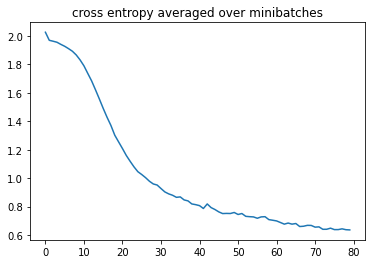

In [ ]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [ ]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 58.7500%
Accuracy of argmax predictions on the test set: 73.750000%
